## 共変量シフト問題 (covariate shift)
### 【課題】 
1. 共変量シフトとは何かを知る。
2. 共変量シフト問題はなぜ起こるのかを理解する。
3. 密度比を用いた共変量シフトを用いた解決策で小さなデータ(banana など) で効果が上がることを確かめる。

In [1]:
import numpy as np
import numpy.random as random
import scipy as sp
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## データの生成

In [23]:
# Train data
df_train = pd.read_csv("banana/banana_train_data_1.asc", sep=' ', header=None, skipinitialspace=True)
df_train["y"] = pd.read_csv("banana/banana_train_labels_1.asc", sep=' ', header=None, skipinitialspace=True)
display(df_train.head(1))

# Test data
df_test = pd.read_csv("banana/banana_test_data_1.asc", sep=' ', header=None, skipinitialspace=True)
df_test["y"] = pd.read_csv("banana/banana_test_labels_1.asc", sep=' ', header=None, skipinitialspace=True)
display(df_test.head(1))

,0,1,y
0,0.658906,-0.985071,1.0


,0,1,y
0,1.13549,-0.113784,-1.0


In [3]:
df_train.describe()

,0,1,y
count,400.000000,400.000000,400.000000
mean,-0.004542,-0.027478,0.085000
std,1.058013,0.942603,0.997629
min,-2.251749,-1.962996,-1.000000
25%,-0.858942,-0.808516,-1.000000
50%,0.037326,-0.041405,1.000000
75%,0.829042,0.615823,1.000000
max,2.642809,2.465340,1.000000


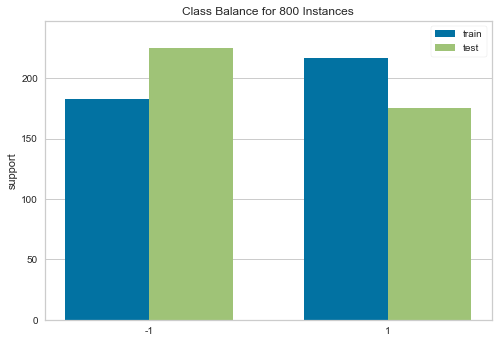

In [131]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["-1","1"])
visualizer.fit(df_train["y"], y_test=df_test["y"][:400])  
visualizer.show()       

## 共変量シフトが発生しているか確認
**以下のヒストグラムを見ると、特徴量ごとの分布の形状にズレが確認できるので、共変量シフトが発生していると判断する** 

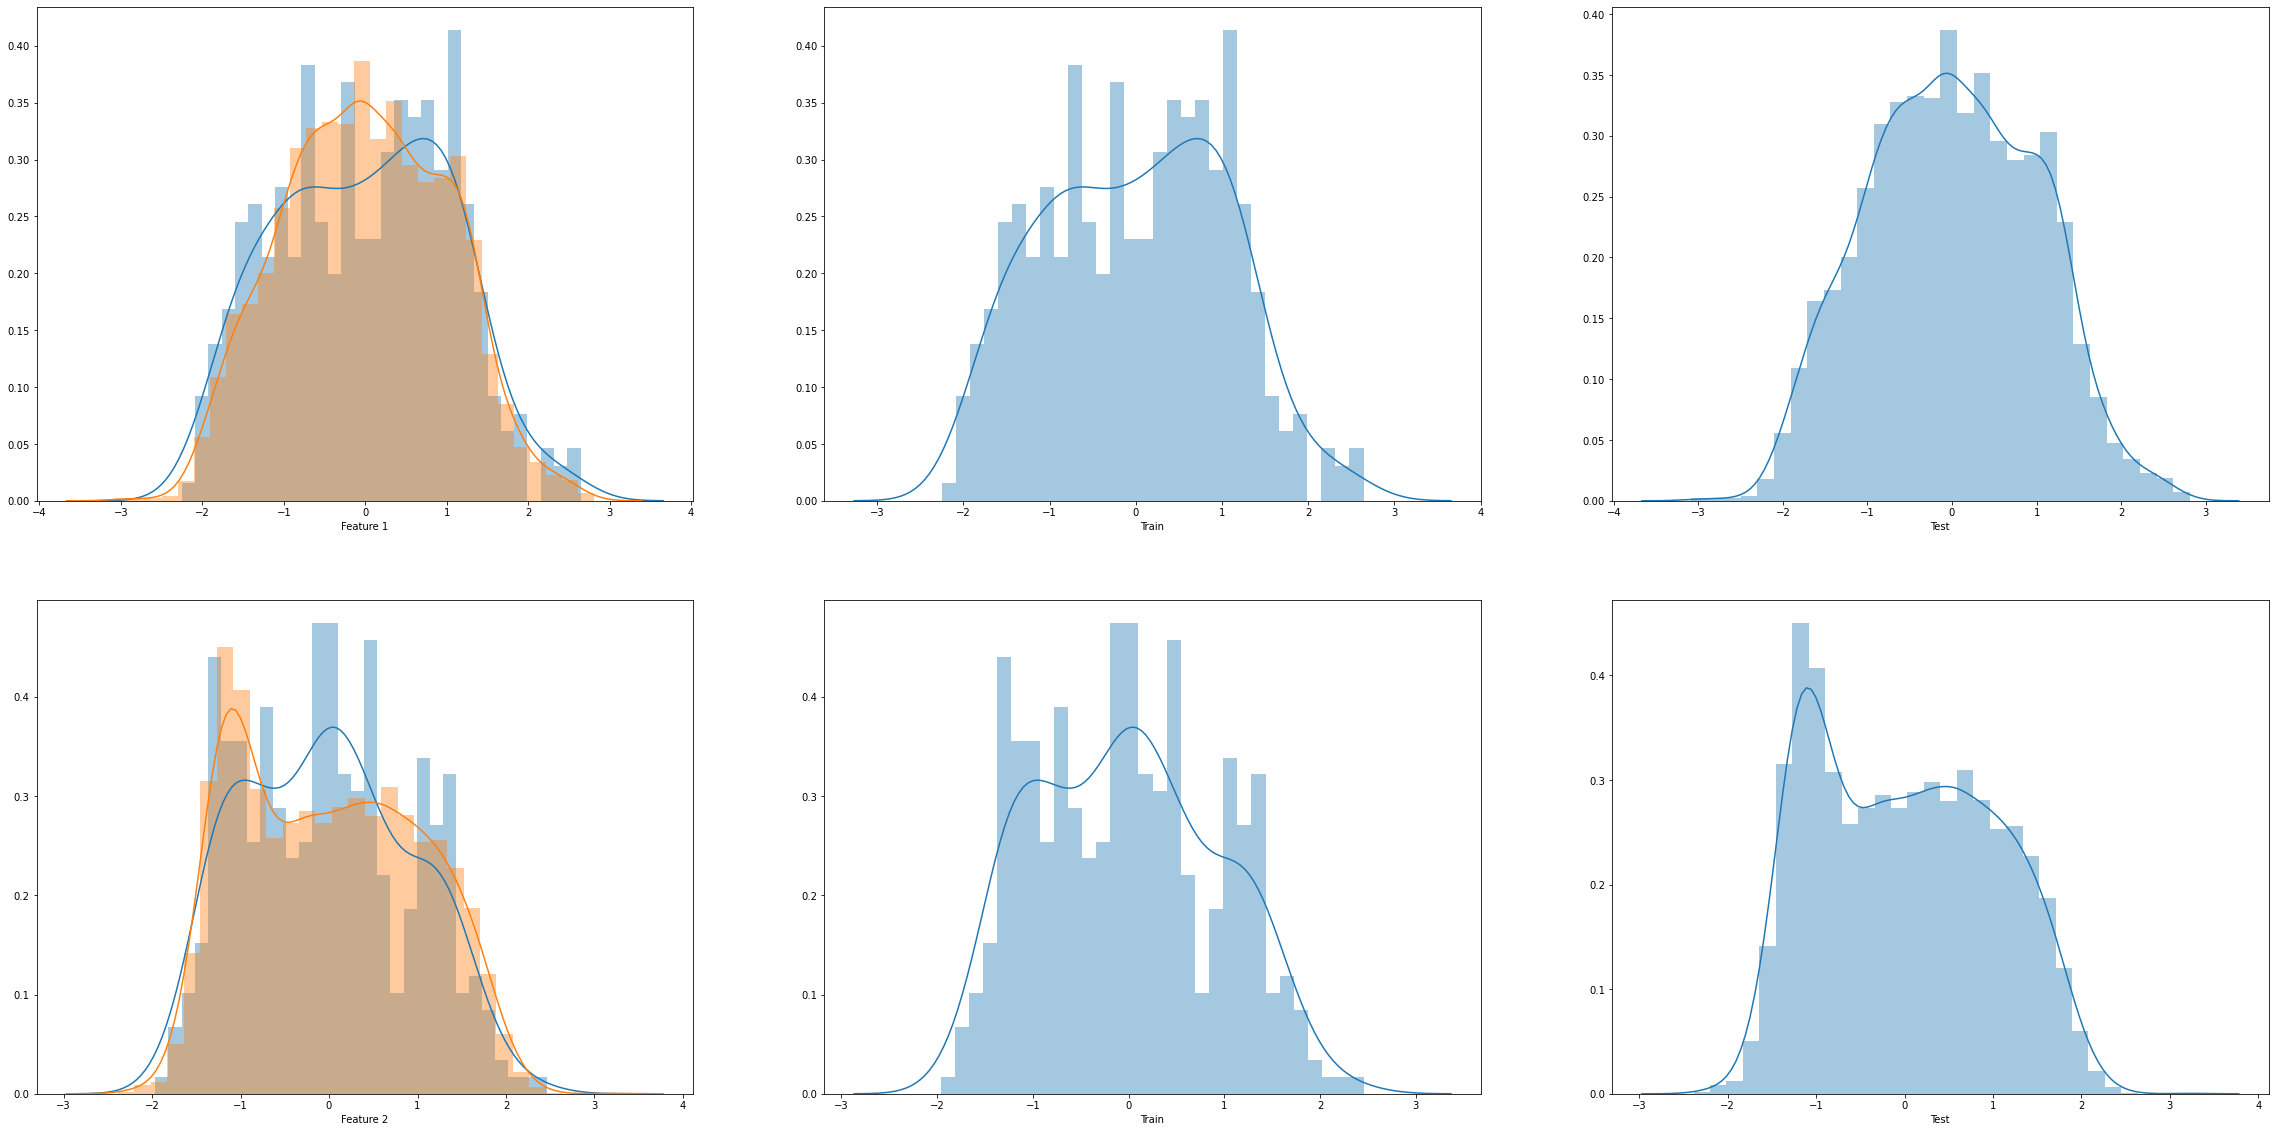

In [24]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(40,20))

''' Histgram Feature 1'''
sns.distplot(
    df_train[0],
    kde=True, rug=False, bins=30,
    ax=ax1
)
sns.distplot(
    df_test[0],
    kde=True, rug=False, bins=30,
    ax=ax1, axlabel="Feature 1"
)
sns.distplot(
    df_train[0],
    kde=True, rug=False, bins=30,
    ax=ax2, axlabel="Train"
)
sns.distplot(
    df_test[0],
    kde=True, rug=False, bins=30,
    ax=ax3, axlabel="Test"
)
      
      
''' Histgram Feature 2'''
sns.distplot(
    df_train[1],
    kde=True, rug=False, bins=30,
    ax=ax4
)
sns.distplot(
    df_test[1],
    kde=True, rug=False, bins=30,
    ax=ax4, axlabel="Feature 2"
)
sns.distplot(
    df_train[1],
    kde=True, rug=False, bins=30,
    ax=ax5, axlabel="Train"
)
sns.distplot(
    df_test[1],
    kde=True, rug=False, bins=30,
    ax=ax6, axlabel="Test"
)
      
plt.show()

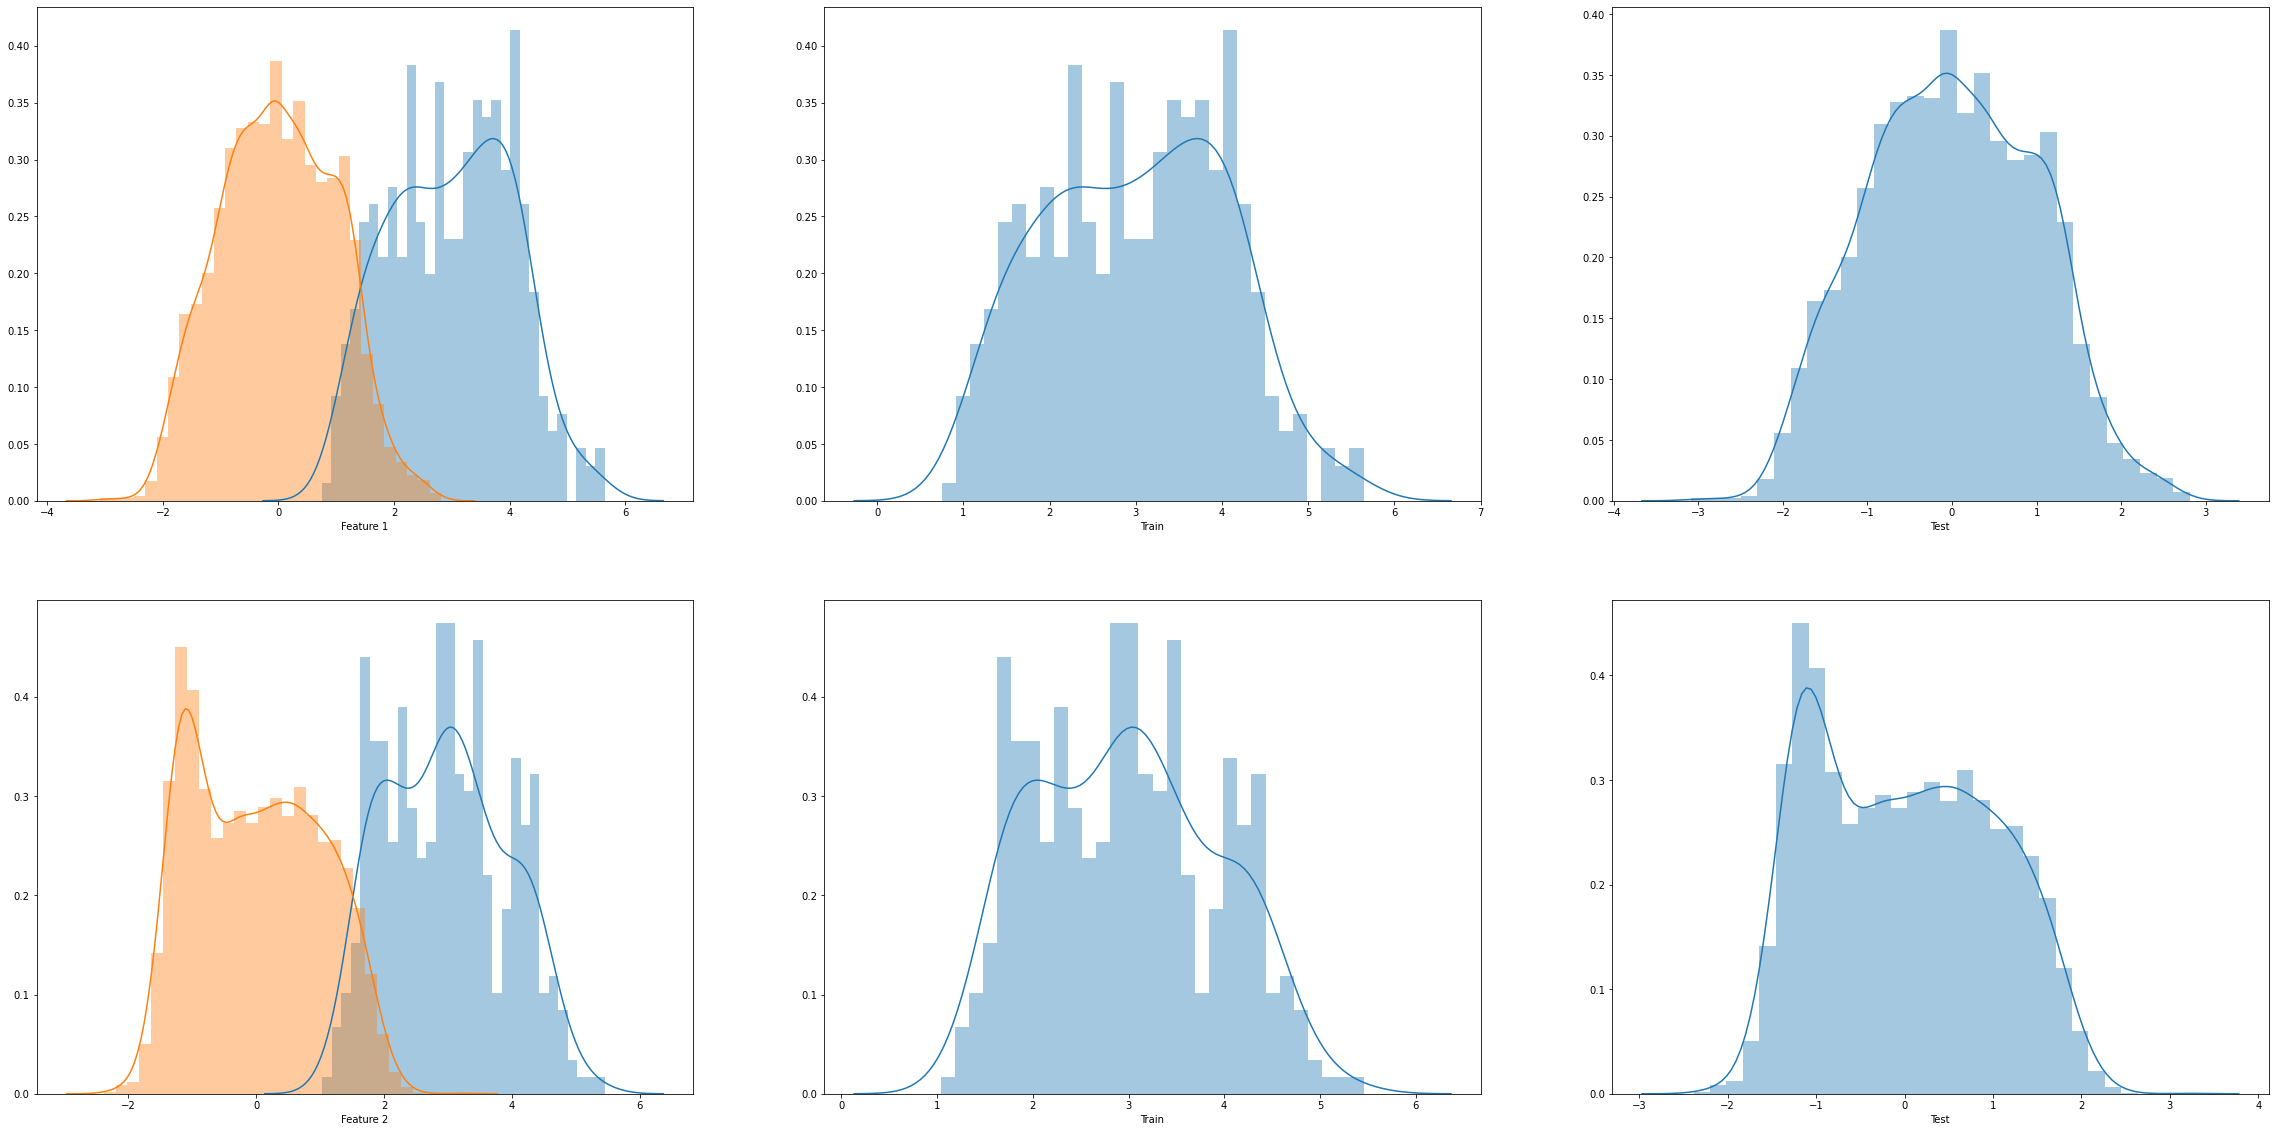

In [25]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(40,20))

df_train[0] = df_train[0]+3
df_train[1] = df_train[1]+3

''' Histgram Feature 1'''
sns.distplot(
    df_train[0],
    kde=True, rug=False, bins=30,
    ax=ax1
)
sns.distplot(
    df_test[0],
    kde=True, rug=False, bins=30,
    ax=ax1, axlabel="Feature 1"
)
sns.distplot(
    df_train[0],
    kde=True, rug=False, bins=30,
    ax=ax2, axlabel="Train"
)
sns.distplot(
    df_test[0],
    kde=True, rug=False, bins=30,
    ax=ax3, axlabel="Test"
)
      
      
''' Histgram Feature 2'''
sns.distplot(
    df_train[1],
    kde=True, rug=False, bins=30,
    ax=ax4
)
sns.distplot(
    df_test[1],
    kde=True, rug=False, bins=30,
    ax=ax4, axlabel="Feature 2"
)
sns.distplot(
    df_train[1],
    kde=True, rug=False, bins=30,
    ax=ax5, axlabel="Train"
)
sns.distplot(
    df_test[1],
    kde=True, rug=False, bins=30,
    ax=ax6, axlabel="Test"
)
      
plt.show()

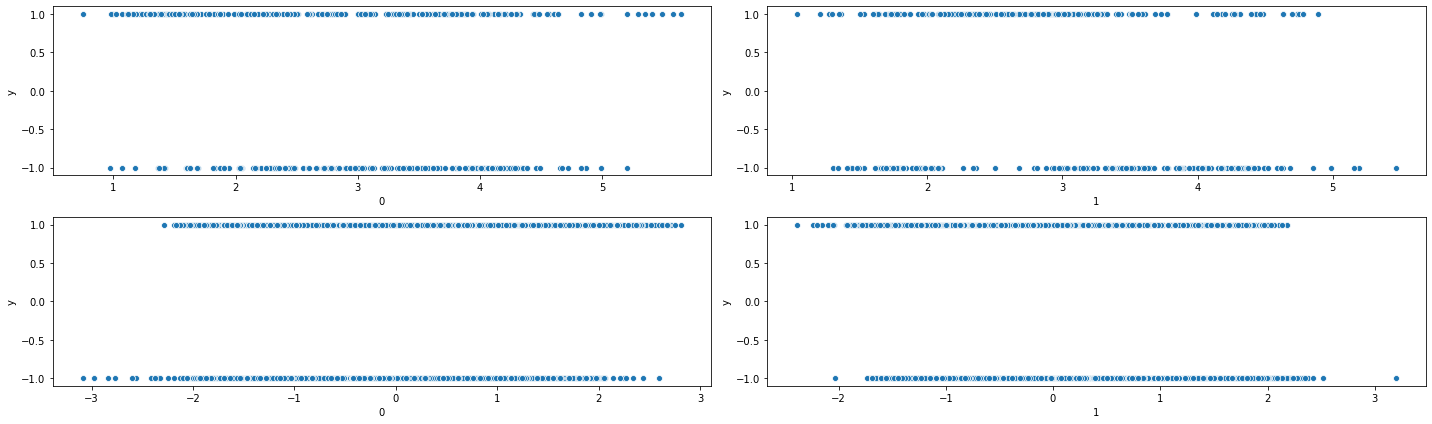

In [27]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(20,6))

sns.scatterplot(data=df_train, x=0, y='y', ax=ax1)
sns.scatterplot(data=df_train, x=1, y='y', ax=ax2)

sns.scatterplot(data=df_test, x=0, y='y', ax=ax3)
sns.scatterplot(data=df_test, x=1, y='y', ax=ax4)

plt.tight_layout()
plt.show()

## ~~確率密度分布~~

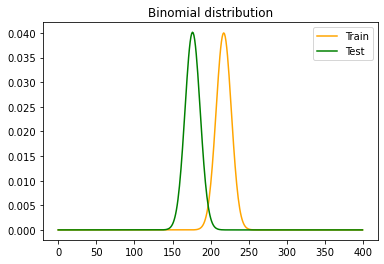

In [15]:
from scipy.stats import binom

# n: trainの数で統一
n = len(df_train)
k = np.arange(0,n)

# Train
p_train = (df_train["y"]==1).sum()/len(df_train["y"]) # p
probd_train = binom.pmf(k, n, p_train, loc=0) # propability distribution

# Test
p_test = (df_test["y"]==1).sum()/len(df_test["y"])
probd_test = binom.pmf(k, n, p_test, loc=0)

plt.plot(k, probd_train, color="orange", label="Train")
plt.plot(k, probd_test, color="green", label="Test")
plt.legend()
plt.title("Binomial distribution")
plt.show()

## kernelDensityRatio
https://github.com/kanamori-takafumi/book_StatMachineLearn_with_Python/blob/master/ch14densityratio.ipynb

In [31]:
from sklearn.ensemble import RandomForestClassifier
from common.DensityRatio import kernelDensityRatio

X_train = df_train.iloc[:,0:2].values
X_test = df_test.iloc[:,0:2].values
y_train = df_train["y"]
y_test = df_test["y"]

# Original
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(f"Original Score = {rf.score(X_test, y_test)}")

gammas = np.array([0.01, 0.1, 1, 10, 100, 1000, 10000])
for g in gammas:
    dr = kernelDensityRatio(gamma=g)
    dr.fit(X_train,X_test) # データへのフィッティング
    weights = dr.predict(X_train)

    rf_KLIEP = RandomForestClassifier()
    rf_KLIEP.fit(X_train, y_train, sample_weight=weights) # Train using the sample weights!
    print(f"Score when applied KDR = {rf_KLIEP.score(X_test, y_test)}, gamma={g}")

Original Score = 0.42857142857142855
Score when applied KDR = 0.4304081632653061, gamma=0.01
Score when applied KDR = 0.43, gamma=0.1
Score when applied KDR = 0.43326530612244896, gamma=1.0
Score when applied KDR = 0.4326530612244898, gamma=10.0
Score when applied KDR = 0.4283673469387755, gamma=100.0
Score when applied KDR = 0.4293877551020408, gamma=1000.0
Score when applied KDR = 0.42857142857142855, gamma=10000.0


<font color="red">１~２%程度、精度が向上したことが確認できた。</font>

### 重み

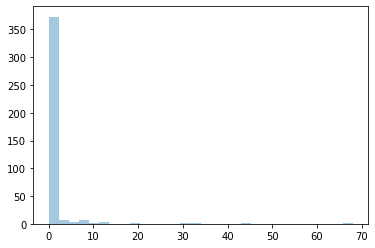

In [14]:
sns.distplot(
    weights,
    kde=False, rug=False, bins=30,
)

## KLIEP algorithm ( Kullback-Leibler Importance Estimation Procedure)
https://github.com/srome/pykliep

In [12]:
import numpy as np
import warnings

class DensityRatioEstimator:
    """
    Class to accomplish direct density estimation implementing the original KLIEP 
    algorithm from Direct Importance Estimation with Model Selection
    and Its Application to Covariate Shift Adaptation by Sugiyama et al. 
    
    The training set is distributed via 
                                            train ~ p(x)
    and the test set is distributed via 
                                            test ~ q(x).
                                            
    The KLIEP algorithm and its variants approximate w(x) = q(x) / p(x) directly. The predict function returns the
    estimate of w(x). The function w(x) can serve as sample weights for the training set during
    training to modify the expectation function that the model's loss function is optimized via,
    i.e.
    
            E_{x ~ w(x)p(x)} loss(x) = E_{x ~ q(x)} loss(x).
    
    Usage : 
        The fit method is used to run the KLIEP algorithm using LCV and returns value of J 
        trained on the entire training/test set with the best sigma found. 

        Use the predict method on the training set to determine the sample weights from the KLIEP algorithm.
    """
    
    def __init__(self, max_iter=5000, num_params=[.1,.2], epsilon=1e-4, cv=3, sigmas=[.01,.1,.25,.5,.75,1], random_state=None, verbose=0):
        """ 
        Direct density estimation using an inner LCV loop to estimate the proper model. Can be used with sklearn
        cross validation methods with or without storing the inner CV. To use a standard grid search.
        
        
        max_iter : Number of iterations to perform
        num_params : List of number of test set vectors used to construct the approximation for inner LCV.
                     Must be a float. Original paper used 10%, i.e. =.1
        sigmas : List of sigmas to be used in inner LCV loop.
        epsilon : Additive factor in the iterative algorithm for numerical stability.
        """
        self.max_iter = max_iter
        self.num_params = num_params
        self.epsilon = epsilon
        self.verbose = verbose
        self.sigmas = sigmas
        self.cv = cv
        self.random_state = 0
        
    def fit(self, X_train, X_test, alpha_0=None):
        """ Uses cross validation to select sigma as in the original paper (LCV).
            In a break from sklearn convention, y=X_test.
            The parameter cv corresponds to R in the original paper.
            Once found, the best sigma is used to train on the full set."""
        
        # LCV loop, shuffle a copy in place for performance.
        cv = self.cv
        chunk = int(X_test.shape[0]/float(cv))
        if self.random_state is not None:
            np.random.seed(self.random_state)
        X_test_shuffled = X_test.copy()
        np.random.shuffle(X_test_shuffled)
        
        j_scores = {}
        
        if type(self.sigmas) != list:
            self.sigmas = [self.sigmas]
        
        if type(self.num_params) != list:
            self.num_params = [self.num_params]
        
        if len(self.sigmas) * len(self.num_params) > 1:
            # Inner LCV loop
            for num_param in self.num_params:
                for sigma in self.sigmas:
                    j_scores[(num_param,sigma)] = np.zeros(cv)
                    for k in range(1,cv+1):
                        if self.verbose > 0:
                            print('Training: sigma: %s    R: %s' % (sigma, k))
                        X_test_fold = X_test_shuffled[(k-1)*chunk:k*chunk,:] 
                        j_scores[(num_param,sigma)][k-1] = self._fit(X_train=X_train, 
                                                         X_test=X_test_fold,
                                                         num_parameters = num_param,
                                                         sigma=sigma)
                    j_scores[(num_param,sigma)] = np.mean(j_scores[(num_param,sigma)])

            sorted_scores = sorted([x for x in j_scores.items() if np.isfinite(x[1])], key=lambda x :x[1], reverse=True)
            # sorted_scores = sorted([x for x in j_scores.iteritems() if np.isfinite(x[1])], key=lambda x :x[1], reverse=True) # 修正前
            if len(sorted_scores) == 0:
                warnings.warn('LCV failed to converge for all values of sigma.')
                return self
            self._sigma = sorted_scores[0][0][1]
            self._num_parameters = sorted_scores[0][0][0]
            self._j_scores = sorted_scores
        else:
            self._sigma = self.sigmas[0]
            self._num_parameters = self.num_params[0]
            # best sigma
        self._j = self._fit(X_train=X_train, X_test=X_test_shuffled, num_parameters=self._num_parameters, sigma=self._sigma)

        return self # Compatibility with sklearn
        
    def _fit(self, X_train, X_test, num_parameters, sigma, alpha_0=None):
        """ Fits the estimator with the given parameters w-hat and returns J"""
        
        num_parameters = num_parameters
        
        if type(num_parameters) == float:
            num_parameters = int(X_test.shape[0] * num_parameters)

        self._select_param_vectors(X_test=X_test, 
                                   sigma=sigma,
                                   num_parameters=num_parameters)
        
        X_train = self._reshape_X(X_train)
        X_test = self._reshape_X(X_test)
        
        if alpha_0 is None:
            alpha_0 = np.ones(shape=(num_parameters,1))/float(num_parameters)
        
        self._find_alpha(X_train=X_train,
                         X_test=X_test,
                         num_parameters=num_parameters,
                         epsilon=self.epsilon,
                         alpha_0 = alpha_0,
                         sigma=sigma)
        
        return self._calculate_j(X_test,sigma=sigma)
    
    def _calculate_j(self, X_test, sigma):
        return np.log(self.predict(X_test,sigma=sigma)).sum()/X_test.shape[0]
    
    def score(self, X_test):
        """ Return the J score, similar to sklearn's API """
        return self._calculate_j(X_test=X_test, sigma=self._sigma)

    @staticmethod   
    def _reshape_X(X):
        """ Reshape input from mxn to mx1xn to take advantage of numpy broadcasting. """
        if len(X.shape) != 3:
            return X.reshape((X.shape[0],1,X.shape[1]))
        return X
    
    def _select_param_vectors(self, X_test, sigma, num_parameters):
        """ X_test is the test set. b is the number of parameters. """ 
        indices = np.random.choice(X_test.shape[0], size=num_parameters, replace=False)
        self._test_vectors = X_test[indices,:].copy()
        self._phi_fitted = True
        
    def _phi(self, X, sigma=None):
        
        if sigma is None:
            sigma = self._sigma
        
        if self._phi_fitted:
            return np.exp(-np.sum((X-self._test_vectors)**2, axis=-1)/(2*sigma**2))
        raise Exception('Phi not fitted.')

    def _find_alpha(self, alpha_0, X_train, X_test, num_parameters, sigma, epsilon):
        A = np.zeros(shape=(X_test.shape[0],num_parameters))
        b = np.zeros(shape=(num_parameters,1))

        A = self._phi(X_test, sigma)
        b = self._phi(X_train, sigma).sum(axis=0) / X_train.shape[0] 
        b = b.reshape((num_parameters, 1))
        
        out = alpha_0.copy()
        for k in range(self.max_iter):
            out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
            out += b*(((1-np.dot(np.transpose(b),out))/np.dot(np.transpose(b),b)))
            out = np.maximum(0,out)
            out /= (np.dot(np.transpose(b),out))
            
        self._alpha = out
        self._fitted = True
        
    def predict(self, X, sigma=None):
        """ Equivalent of w(X) from the original paper."""
        
        X = self._reshape_X(X)
        if not self._fitted:
            raise Exception('Not fitted!')
        return np.dot(self._phi(X, sigma=sigma), self._alpha).reshape((X.shape[0],))

    

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier,LinearRegression
# LogisticRegression(),RidgeClassifier(),RandomForestClassifier(),

X_train = df_train.iloc[:,0:2].values
X_test = df_test.iloc[:,0:2].values
y_train = df_train["y"]
y_test = df_test["y"]

# Original
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(f"Original Score = {rf.score(X_test, y_test)}")


# KLIEP algorithm
kliep = DensityRatioEstimator()
kliep.fit(X_train, X_test) # keyword arguments are X_train and X_test
weights = kliep.predict(X_train)

rf_KLIEP = RandomForestClassifier()
rf_KLIEP.fit(X_train, y_train, sample_weight=weights) # Train using the sample weights!
print(f"Score when applied KLIEP = {rf_KLIEP.score(X_test, y_test)}")

Original Score = 0.4281632653061225


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: divide by zero encountered in true_divide
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: overflow encountered in true_divide


Score when applied KLIEP = 0.4304081632653061


その他パッケージ https://pypi.org/project/densratio/

## 別データ

In [125]:
X_train = df_train.iloc[:,0:2].values
X_test = df_test.iloc[:,0:2].values
y_train = df_train["y"]
y_test = df_test["y"]

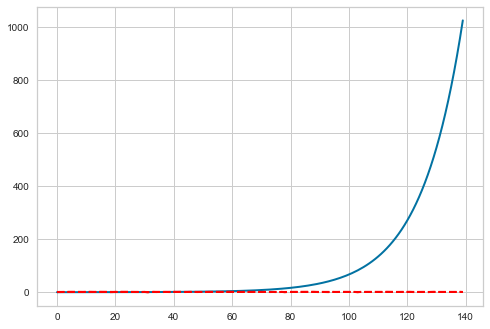

In [126]:
from common.DensityRatio import kernelDensityRatio

# Density ratio
dr_true = probd_train/probd_test
# 真の密度比関数のプロット 
plt.plot(k, dr_true, lw=2)

gammas = np.array([0.01, 0.1, 1])
for g in gammas:
    dr = kernelDensityRatio(gamma=g)
    dr.fit(X_train,X_test) # データへのフィッティング
    weights = dr.predict(X_train)
    plt.plot(k, weights, c='red',linestyle='dashed',lw=2)  # プロット
plt.show()

In [103]:
''' cancer '''
# Train data
df_train = pd.read_csv("breast-cancer/breast-cancer_train_data_1.asc", sep=' ', header=None, skipinitialspace=True)
df_train["y"] = pd.read_csv("breast-cancer/breast-cancer_train_labels_1.asc", sep=' ', header=None, skipinitialspace=True)
display(df_train.head(1))

# Test data
df_test = pd.read_csv("breast-cancer/breast-cancer_test_data_1.asc", sep=' ', header=None, skipinitialspace=True)
df_test["y"] = pd.read_csv("breast-cancer/breast-cancer_test_labels_1.asc", sep=' ', header=None, skipinitialspace=True)
display(df_test.head(1))

,0,1,2,3,4,5,6,7,8,y
0,-0.698857,0.903637,0.595989,1.056742,-1.76876,1.212478,0.97476,-0.982302,0.516293,1.0


,0,1,2,3,4,5,6,7,8,y
0,0.29847,-0.890541,0.132066,1.056742,0.561241,1.212478,-1.018406,-0.176462,-1.922747,1.0


In [29]:
''' solar '''
# Train data
df_train = pd.read_csv("flare-solar/flare-solar_train_data_1.asc", sep=' ', header=None, skipinitialspace=True)
df_train["y"] = pd.read_csv("flare-solar/flare-solar_train_labels_1.asc", sep=' ', header=None, skipinitialspace=True)
display(df_train.head(1))

# Test data
df_test = pd.read_csv("flare-solar/flare-solar_test_data_1.asc", sep=' ', header=None, skipinitialspace=True)
df_test["y"] = pd.read_csv("flare-solar/flare-solar_test_labels_1.asc", sep=' ', header=None, skipinitialspace=True)
display(df_test.head(1))

,0,1,2,3,4,5,6,7,8,y
0,1.0,3.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0


,0,1,2,3,4,5,6,7,8,y
0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,-1.0


In [120]:
''' thyroid '''
# Train data
df_train = pd.read_csv("thyroid/thyroid_train_data_8.asc", sep=' ', header=None, skipinitialspace=True)
df_train["y"] = pd.read_csv("thyroid/thyroid_train_labels_8.asc", sep=' ', header=None, skipinitialspace=True)
display(df_train.head(1))

# Test data
df_test = pd.read_csv("thyroid/thyroid_train_data_88.asc", sep=' ', header=None, skipinitialspace=True)
df_test["y"] = pd.read_csv("thyroid/thyroid_train_labels_88.asc", sep=' ', header=None, skipinitialspace=True)
display(df_test.head(1))

,0,1,2,3,4,y
0,2.047448,-0.039098,0.905876,-0.299802,-0.276506,-1.0


,0,1,2,3,4,y
0,-0.553036,-0.384712,-0.455661,-0.343548,-0.044763,-1.0


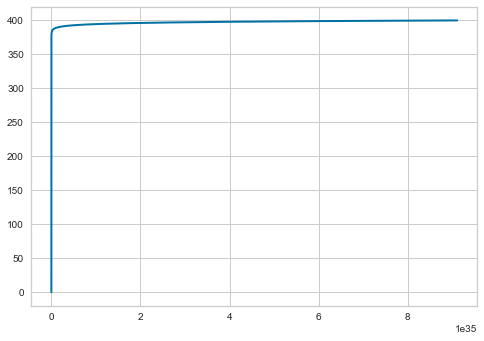

In [78]:
from common.DensityRatio import kernelDensityRatio

# Density ratio
dr_true = probd_train/probd_test
# 真の密度比関数のプロット
# plt.plot(k, dr_true, lw=2) 
plt.plot(dr_true, k, lw=2) 

# データ点のプロット
# plt.scatter(nu.reshape(n,),np.repeat(0.3,n),marker='.',c='black',s=20)
# plt.scatter(de.reshape(m,),np.repeat(0.1,m),marker='x',c='gray',s=20)

# 以下のカーネル幅で推定
# gammas = np.array([0.01, 0.1, 1])
# for g in gammas:
#     dr = kernelDensityRatio(gamma=g)
#     dr.fit(de,nu)                   # データへのフィッティング
#     drp = dr.predict(newdat)        # 密度比の予測値
#     plt.plot(newdat,drp, c='red',linestyle='dashed',lw=2)  # プロット
# plt.show()

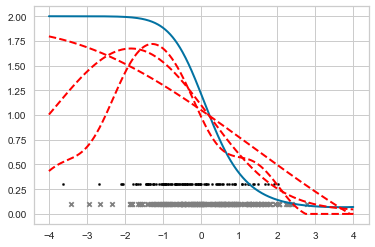

In [76]:
from common.DensityRatio import kernelDensityRatio
plt.plot(newdat,tw,lw=2)            # 真の密度比関数のプロット

# データ点のプロット
plt.scatter(nu.reshape(n,),np.repeat(0.3,n),marker='.',c='black',s=20)
plt.scatter(de.reshape(m,),np.repeat(0.1,m),marker='x',c='gray',s=20)

# 以下のカーネル幅で推定
gammas = np.array([0.01, 0.1, 1])
for g in gammas:
    dr = kernelDensityRatio(gamma=g)
    ma = np.random.binomial(m,0.5)
    dr.fit(de,ma)                   # データへのフィッティング
    drp = dr.predict(newdat)        # 密度比の予測値
    plt.plot(newdat,drp, c='red',linestyle='dashed',lw=2)  # プロット
plt.show()